In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-15 06:09:28.852598: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-15 06:09:30.267695: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-15 06:09:30.313354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-15 06:09:30.313448: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-15 06:09:30.326453: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-15 06:09:30.326510: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-15 06:09:30.333717: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

refit_gen_GASF_60m_300S0X_15A157030N_R42_80-20-V1


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.2602198297365584, 1: 0.40103670634920635, 2: 2.4953395061728396, 3: 8.651578384162654, 4: 8.369461697722567, 5: 0.8347426565484487, 6: 8.421770833333333, 7: 0.863218022635063, 8: 4.254091028676664, 9: 8.10516290726817, 10: 8.421770833333333, 11: 0.4771541548630784, 12: 1.9194919278252611, 13: 4.587177304964539, 14: 0.4462973696558196}
 
Tests 
HEKA test: 5178 train: 20713
fridge/freezer test: 3360 train: 13440
audio system test: 540 train: 2160
breadmaker test: 156 train: 623
broadband router test: 161 train: 644
computer test: 1614 train: 6457
dehumidifier test: 160 train: 640
dish washer test: 1561 train: 6244
electric space heater test: 317 train: 1267
food processor test: 166 train: 665
pond pump test: 160 train: 640
television test: 2824 

In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/refit/TL/refit_42_iawe,redd_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data refit training on model iawe seed 42
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.2602198297365584, 1: 0.40103670634920635, 2: 2.4953395061728396, 3: 8.651578384162654, 4: 8.369461697722567, 5: 0.8347426565484487, 6: 8.421770833333333, 7: 0.863218022635063, 8: 4.254091028676664, 9: 8.10516290726817, 10: 8.421770833333333, 11: 0.4771541548630784, 12: 1.9194919278252611, 13: 4.587177304964539, 14: 0.4462973696558196}
 
Tests 
HEKA test: 5178 train: 20713
fridge/freezer test: 3360 train: 13440
audio system test: 540 train: 2160
breadmaker test: 156 train: 623
broadband router test: 161 train: 644
computer test: 1614 train: 6457
dehumidifier test: 160 train: 640
dish washer test: 1561 train: 6244
electric space heater test: 317 train: 1267
fo

2022-02-15 06:09:48.944157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-15 06:09:48.944728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-15 06:09:48.945255: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-15 06:09:49.820892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-15 06:09:49.820928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-15 06:09:49.821095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-15 06:09:49.821860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-15 06:09:50.437234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-15 06:09:50.456516: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/25


2022-02-15 06:09:50.996523: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-15 06:09:51.772978: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-15 06:09:52.652653: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-15 06:09:53.458307: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2527/2527 - 129s - loss: 2.7341 - accuracy: 0.0349
Epoch 2/25
2527/2527 - 127s - loss: 2.7088 - accuracy: 0.0285
Epoch 3/25
2527/2527 - 125s - loss: 2.7089 - accuracy: 0.0763
Epoch 4/25
2527/2527 - 125s - loss: 2.7087 - accuracy: 0.0291
Epoch 5/25
2527/2527 - 126s - loss: 2.7089 - accuracy: 0.0179
Epoch 6/25
2527/2527 - 125s - loss: 2.7089 - accuracy: 0.0495
Epoch 7/25
2527/2527 - 126s - loss: 2.7139 - accuracy: 0.0229
Epoch 8/25
2527/2527 - 125s - loss: 2.7089 - accuracy: 0.0155
Epoch 9/25
2527/2527 - 126s - loss: 2.7089 - accuracy: 0.0636
Epoch 10/25
2527/2527 - 125s - loss: 2.7087 - accuracy: 0.0396
Epoch 11/25
2527/2527 - 125s - loss: 2.7089 - accuracy: 0.0363
Epoch 12/25
2527/2527 - 123s - loss: 2.7090 - accuracy: 0.0330
Epoch 13/25
2527/2527 - 125s - loss: 2.7089 - accuracy: 0.0405
Epoch 14/25
2527/2527 - 124s - loss: 2.7089 - accuracy: 0.0443
Epoch 15/25
2527/2527 - 125s - loss: 2.7089 - accuracy: 0.0462
Epoch 16/25
2527/2527 - 124s - loss: 2.7089 - accuracy: 0.0507
Epoch 17/25


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{0: 0.2602198297365584, 1: 0.40103670634920635, 2: 2.4953395061728396, 3: 8.651578384162654, 4: 8.369461697722567, 5: 0.8347426565484487, 6: 8.421770833333333, 7: 0.863218022635063, 8: 4.254091028676664, 9: 8.10516290726817, 10: 8.421770833333333, 11: 0.4771541548630784, 12: 1.9194919278252611, 13: 4.587177304964539, 14: 0.4462973696558196}
 
Tests 
HEKA test: 5178 train: 20713
fridge/freezer test: 3360 train: 13440
audio system test: 540 train: 2160
breadmaker test: 156 train: 623
broadband router test: 161 train: 644
computer test: 1614 train: 6457
dehumidifier test: 160 train: 640
dish washer test: 1561 train: 6244
electric space heater test: 317 train: 1267
food processor test: 166 train: 665
pond pump test: 160 train: 640
television test: 2824 train: 11296
tumble dryer test: 702 train: 2808
washer dryer test: 294 train: 1175
washing machine test: 3020 train: 12077
loading model
compling TL model..


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/25
2527/2527 - 129s - loss: 3.0523 - accuracy: 0.0290
Epoch 2/25
2527/2527 - 133s - loss: 2.7089 - accuracy: 0.0418
Epoch 3/25
2527/2527 - 131s - loss: 2.7090 - accuracy: 0.0371
Epoch 4/25
2527/2527 - 134s - loss: 2.7219 - accuracy: 0.0476
Epoch 5/25
2527/2527 - 135s - loss: 2.7088 - accuracy: 0.0208
Epoch 6/25
2527/2527 - 132s - loss: 2.7088 - accuracy: 0.0427
Epoch 7/25
2527/2527 - 132s - loss: 2.7088 - accuracy: 0.0321
Epoch 8/25
2527/2527 - 132s - loss: 2.7089 - accuracy: 0.0363
Epoch 9/25
2527/2527 - 133s - loss: 2.7088 - accuracy: 0.0342
Epoch 10/25
2527/2527 - 131s - loss: 2.7090 - accuracy: 0.0523
Epoch 11/25
2527/2527 - 133s - loss: 2.7089 - accuracy: 0.0397
Epoch 12/25
2527/2527 - 131s - loss: 2.7089 - accuracy: 0.0379
Epoch 13/25
2527/2527 - 135s - loss: 2.7088 - accuracy: 0.0405
Epoch 14/25
2527/2527 - 133s - loss: 2.7088 - accuracy: 0.0434
Epoch 15/25
2527/2527 - 133s - loss: 2.7090 - accuracy: 0.0277
Epoch 16/25
2527/2527 - 132s - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                 HEKA       0.00      0.00      0.00      5178
       fridge/freezer       0.00      0.00      0.00      3360
         audio system       0.00      0.00      0.00       540
           breadmaker       0.00      0.00      0.00       156
     broadband router       0.00      0.00      0.00       161
             computer       0.00      0.00      0.00      1614
         dehumidifier       0.00      0.00      0.00       160
          dish washer       0.00      0.00      0.00      1561
electric space heater       0.00      0.00      0.00       317
       food processor       0.00      0.00      0.00       166
            pond pump       0.01      1.00      0.02       160
           television       0.00      0.00      0.00      2824
         tumble dryer       0.00      0.00      0.00       702
         washer dryer       0.00      0.00      0.00       294
      washing machine       0.00      0.00      0.00  

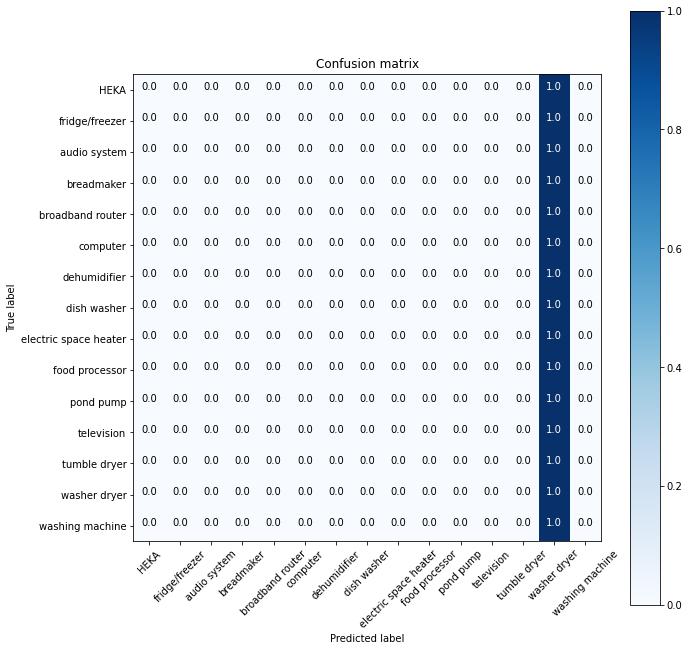

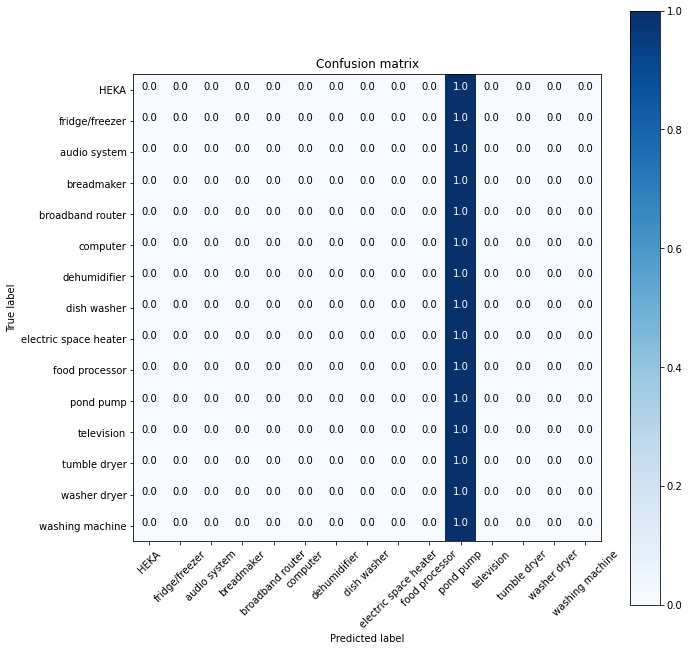

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()